In [1]:
from __future__ import annotations
import numpy as np
from scipy import integrate
from scipy import special
from matplotlib import pyplot as plt
from typing import Optional
import os
from scipy.constants import physical_constants as constants

import torch
from torch import nn
from torch import optim
from tqdm import trange

temperature_unit = 'K'
time_unit = 'fs'
energy_unit = '/cm'

au2fs = 0.02418884254
au2cm = 219474.6305
au2kelvin = 3.1577465e5 

PI = np.pi

In [2]:
class BoseEinstein(object):
    decomposition_method = 'Pade'  # type: Literal['Pade', 'Matsubara']
    pade_type = '(N-1)/N'  # type: Literal['(N-1)/N']

    def __init__(self, n: int = 0, beta: Optional[float] = None) -> None:
    #def __init__(self, n: int = 0, beta: float = None) -> None:
        """
        Args: 
            n: Number of low-temperature correction terms.
            beta: inversed temperature, `None` indicates zero temperature. 
        """
        if beta is not None:
            assert beta >= 0

        self.n = n
        self.beta = beta

        return

    def __str__(self) -> str:
        if self.decomposition_method == 'Pade':
            info = f'Padé[{self.pade_type}]'
        else:
            info = self.decomposition_method
        return f'Bose-Einstein at ß = {self.beta:.4f} ({info}; N={self.n})'

    def function(self, w: complex) -> complex:
        beta = self.beta
        if beta is None:
            return 1.0
        else:
            return 1.0 / (1.0 - np.exp(-beta * w))

    @property
    def residues(self) -> list[tuple[complex, complex]]:
        method = NotImplemented
        if self.decomposition_method == 'Pade':
            if self.pade_type == '(N-1)/N':
                method = self.pade1
        elif self.decomposition_method == 'Matsubara':
            method = self.matsubara

        if method is NotImplemented:
            raise NotImplementedError

        n = self.n
        b = self.beta
        if b is None or n == 0:
            ans = []
        else:
            residues, zetas = method(n)
            ans = [(r / b, -1.0j * z / b) for r, z in zip(residues, zetas)]
        return ans

    @staticmethod
    def matsubara(n: int) -> tuple[Array, Array]:
        zetas = [2.0 * PI * (i + 1) for i in range(n)]
        residues = [1.0] * n
        return array(residues), array(zetas)

    @staticmethod
    def pade1(n: int) -> tuple[Array, Array]:
        # (N-1)/N method
        assert n > 0

        subdiag_q = array([1.0 / np.sqrt((2 * i + 3) * (2 * i + 5)) for i in range(2 * n - 1)])
        zetas = 2.0 / _tridiag_eigsh(subdiag_q)[:n]
        roots_q = np.power(zetas, 2)

        subdiag_p = array([1.0 / np.sqrt((2 * i + 5) * (2 * i + 7)) for i in range(2 * n - 2)])
        roots_p = np.power(2.0 / _tridiag_eigsh(subdiag_p)[:n - 1], 2)

        residues = np.zeros((n,))
        for i in range(n):
            res_i = 0.5 * n * (2 * n + 3)
            if i < n - 1:
                res_i *= (roots_p[i] - roots_q[i]) / (roots_q[n - 1] - roots_q[i])
            for j in range(n - 1):
                if j != i:
                    res_i *= ((roots_p[j] - roots_q[i]) / (roots_q[j] - roots_q[i]))
            residues[i] = res_i

        return array(residues), array(zetas)
    
class SpectralDensity:

    def function(self, w: complex) -> complex:
        pass

    def get_htc(self, distr: BoseEinstein) -> tuple[list[complex], list[complex], list[complex]]:
        pass

class Drude(SpectralDensity):

    def __init__(self, reorganization_energy: float, relaxation: float) -> None:
        self.l = reorganization_energy
        self.g = relaxation
        return

    def function(self, w: complex) -> complex:
        l = self.l
        g = self.g
        return (2.0 / PI) * l * g * w / (w**2 + g**2)

    def get_htc(self, distr: BoseEinstein) -> tuple[list[complex], list[complex], list[complex]]:
        _c = -2.0j * self.l * self.g * distr.function(-1.0j * self.g)
        _d = -self.g
        coefficients = [_c]
        conj_coefficents = [np.conj(_c)]
        derivatives = [_d]
        return coefficients, conj_coefficents, derivatives

class UnderdampedBrownian(SpectralDensity):

    def __init__(self, reorganization_energy: float, frequency: float, relaxation: float) -> None:
        self.w0 = frequency
        self.g = relaxation
        self.l = reorganization_energy
        return

    def function(self, w: complex) -> complex:
        l = self.l
        g = self.g
        w0 = self.w0
        return (4.0 / PI) * l * g * (w0**2 + g**2) * w / ((w + w0)**2 + g**2) / ((w - w0)**2 + g**2)

    def get_htc(self, distr: BoseEinstein) -> tuple[list[complex], list[complex], list[complex]]:
        f = distr.function
        l = self.l
        g = self.g
        w0 = self.w0

        a = l * (w0**2 + g**2) / w0
        c1 = +a * f(-1.0j * (g + 1.0j * w0))
        c2 = -a * f(-1.0j * (g - 1.0j * w0))

        coefficients = [c1, c2]
        conj_coefficents = [np.conj(c2), np.conj(c1)]
        derivatives = [-(g + 1.0j * w0), -(g - 1.0j * w0)]
        return coefficients, conj_coefficents, derivatives

In [3]:
# Generate the integration parameters
#scaling = 1.0 / (1000 / au2cm)
scaling = 1
print(scaling)

int_freq_min = (1.0e-7 / au2cm ) * scaling
int_freq_max = (1.0e7 / au2cm) * scaling
int_num = 100000
w = np.logspace(np.log2(int_freq_min), np.log2(int_freq_max), num=int_num, base=2)
#w = np.linspace(0, int_freq_max, num=int_num)

n_pts = 2000
t_learn = (1.0e3 / au2fs) / scaling
t_test = t_learn#(1.0e3 / au2fs) / scaling
t_min = (1.0e-3 / au2fs) / scaling
# = np.logspace(np.log2(t_min), np.log2(t_learn), num=n_pts, base=2)
#test_domain = np.logspace(np.log2(t_min), np.log2(t_test), num=n_pts, base=2)
learn_domain = np.linspace(0, t_learn, num=n_pts)
test_domain = np.linspace(0, t_test, num=n_pts)
print(t_learn)

1
41341.37457575099


In [8]:
include_drude = True
re_d = 200 / au2cm * scaling
width_d = 50 / au2cm * scaling

sds = []  # type:list[SpectralDensity]
if include_drude:
    drude = Drude(
        re_d,
        width_d)
    
    sds.append(drude)

    
include_brownian = True
dof = 10
freq_max = 2000 / au2cm * scaling
re_b = 1000 / au2cm * scaling
width_b = 5 / au2cm * scaling

if include_brownian:
    freq_space = [freq_max / (dof + 1) * (n + 1) for n in range(dof)]
    for _n, freq in enumerate(freq_space):
        b = UnderdampedBrownian(
            re_b / dof / (_n + 1),
            freq,
            width_b,
        )
        sds.append(b)

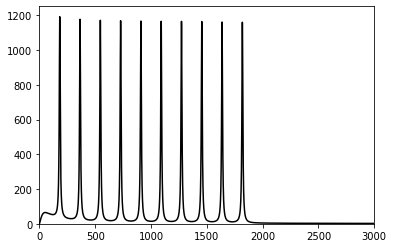

In [9]:
j = np.zeros_like(w) 
for sd in sds:
    j += sd.function(w)
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
plt.plot(w * au2cm /scaling, j* au2cm, 'k-') 
plt.ylim(bottom=0)
#plt.xscale('log')
plt.xlim(0, 3000)
plt.show()


In [41]:
#ph_parameters = []

PI = np.pi

n_sample = 100000

int_freq_max = 10000/au2cm

fs2au = 41.341374575751
def pure_dephasing_coherence(beta, t, ph_parameters=None, bsds=None):
    """
    bsd: bath sepctral density of type (float -> float)

    """
    ans = 0.0
    if ph_parameters is not None:
        for w, g in ph_parameters:
            ans += (g**2) / (w**2) * (np.cos(w * t) - 1) / np.tanh(beta * w / 2.0)
    if bsds is not None:
        for bsd in bsds:
            ans += integrate.quad(
                lambda w: bsd(w) / (w**2) * (np.cos(w * t) - 1) / np.tanh(beta * w / 2.0),
                0,
                int_freq_max,
            )[0]
    return np.exp(ans)

def gen_ref(beta, dof):
    beta = beta * au2kelvin
    freq_max = 2000
    re_b = 1000
    width_b = 50
    re_d = 200
    width_d = 100
    #t = np.linspace(0, 50, 500) * fs2au
    t = np.linspace(0, 60, 500) /au2fs
    # Bath settings:
    drude = Drude(re_d/ au2cm, width_d/ au2cm)
    sds = [drude]  # type:list[SpectralDensity]
    freq_space = [freq_max / (dof + 1) * (n + 1) for n in range(dof)]
    # freq_space =[]
    for _n, freq in enumerate(freq_space):
        b = UnderdampedBrownian(re_b / dof / (_n + 1)/ au2cm,freq/ au2cm, width_b/ au2cm)
        sds.append(b)
    bsds = [sd.function for sd in sds]
    coh = np.array([pure_dephasing_coherence(beta, ti, bsds=bsds) for ti in t])
    return t, coh

t, ga = gen_ref(1/300, 10)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


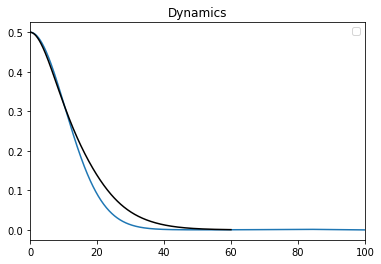

In [42]:

file_good = open('0111_1d10b.txt', 'r')
good = np.loadtxt(file_good ,delimiter = " ", dtype = complex)

plt.figure()#figsize = (10,5))

plt.title('Dynamics')
#ax1.set_xscale('log')
compare = np.abs(good[:, 2])
plt.plot(good[:, 0]*au2fs, compare)
plt.plot(t*au2fs, ga/2, 'k-')
plt.xlim(0, 100)
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
plt.legend()
plt.show()

In [11]:
def gen_target_func(beta):
    ph_parameters = []
    bsds = [sd.function for sd in sds]
    w = np.logspace(np.log2(int_freq_min), np.log2(int_freq_max), num=int_num, base=2)

    def _re(t):
        def _re_i(t_i):
            ans = 0.0
            for omega, g in ph_parameters:
                ans += (g**2) * np.cos(omega * t_i) / np.tanh(beta * omega / 2.0)
            for bsd in bsds:
                f = bsd(w) * np.cos(w * t_i) / np.tanh(beta * w / 2.0)
                ans += integrate.simpson(f, w)
            return ans
        return np.array([_re_i(t_i) for t_i in t])

    def _im(t):
        def _im_i(t_i):
            ans = 0.0
            for omega, g in ph_parameters:
                ans -= (g**2) * np.sin(omega * t_i)
            for bsd in bsds:
                f = bsd(w) * np.sin(w * t_i)
                ans -= integrate.simpson(f, w)
            return ans
        return np.array([_im_i(t_i) for t_i in t])

    return _re, _im

In [12]:
beta = 1052.6#1/(300) * constants["kelvin-hartree relationship"][0]
print(beta)
re, im = gen_target_func(beta = beta)
learn_s = re(learn_domain)
test_s = re(test_domain)
learn_a = im(learn_domain)
test_a = im(test_domain)

1052.6


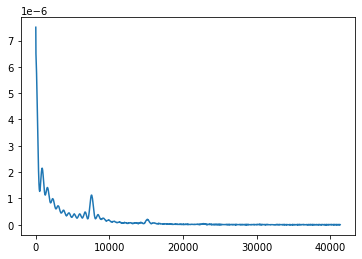

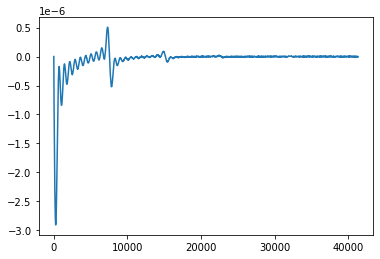

In [13]:
#plt.plot(learn_domain, learn_s)
plt.plot(learn_domain, learn_s)
#plt.xscale('log')
plt.show()
plt.plot(learn_domain, learn_a)
#plt.xscale('log')
plt.show()

In [14]:
#np.savetxt('drude_brownian.csv',[w / scaling * au2cm, j], delimiter=',')#, fmt='%1.4e')
#np.savetxt('drude_brownian_4.csv', j, delimiter=',')
np.savetxt('drude_brownian_10_lin_short.csv', j, delimiter=',')
#np.savetxt('drude_brownian_4_lin.csv', j, delimiter=',')
#np.savetxt('drude_data.csv', j, delimiter=',')
#np.savetxt('learn_db_4.csv',[learn_s, test_s,learn_a, test_a], delimiter=',')
np.savetxt('learn_db_10_short.csv',[learn_s, test_s,learn_a, test_a], delimiter=',')
#np.savetxt('learn_db_4_lin.csv',[learn_s, test_s,learn_a, test_a], delimiter=',')
#np.savetxt('learn_s.csv',[learn_s, test_s,learn_a, test_a], delimiter=',')

In [34]:
#file = open('learn_s.csv', 'r')
#read_s = np.loadtxt(file ,delimiter = ",")

In [25]:
#np.savetxt('drude_brownian_10_lin_short.csv', j, delimiter=',')
np.savetxt('BCF_SPD_TMD.csv',[learn_s,learn_a], delimiter=',')

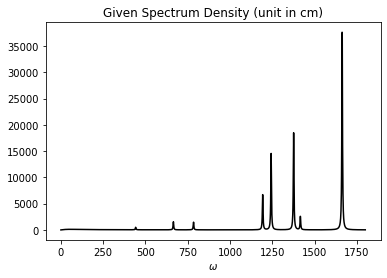

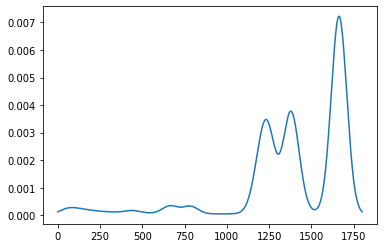

0.0


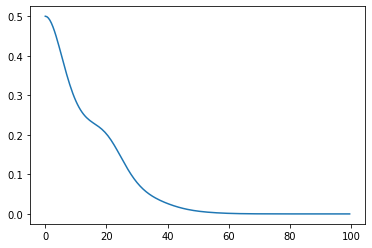

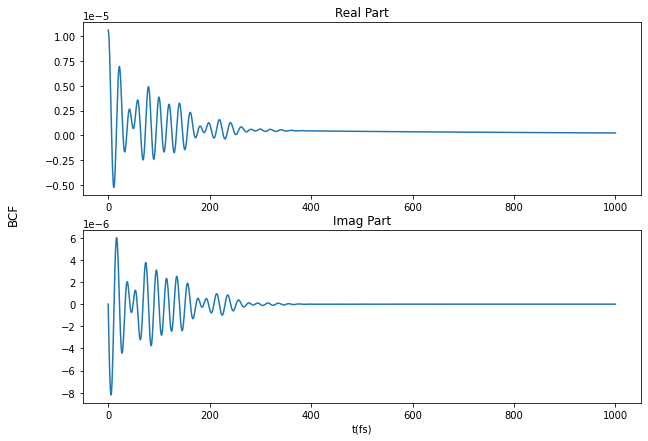

In [6]:
file = open('SPD-TMP.txt','r')
sd = np.loadtxt(file, delimiter = "\t", dtype = float)
w = sd[:, 0]
col_2 = sd[:, 1]
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
plt.plot(w, col_2, 'k-')
plt.xlabel('$\omega$')
plt.title('Given Spectrum Density (unit in cm)')
plt.show()

def _re(j, w, beta, t):
    # want to integrate over for ever t in the lest
    y = j * np.cos(w * t) / np.tanh(beta * w / 2.0)
    return integrate.simpson(y, x=w)
def _im(j, w, beta, t):
    y = j * np.sin(w * t)
    return -integrate.simpson(y, x=w)
beta = 1052.6
def Gaussian(x, x0, sigma):
    return np.exp(-(x - x0)**2/(2*sigma**2))/(2 * np.pi*sigma**2)

w = sd[1:, 0]
x = np.linspace(-100, 100, len(w))
d = np.convolve(sd[1:, 1] / au2cm, Gaussian(x, 0, 5),'same')

def Gamma(j, w, beta, t):
    y = j/w**2 * (1 - np.cos(w * t))/ np.tanh(beta * w / 2.0)
    return -integrate.simpson(y, x=w)

plt.plot(w, d)#sd[1:, 1]/ au2cm)
plt.show()
#d = sd[1:, 1] / au2cm               


t_range = np.where(learn_domain*au2fs <= 100)
t = learn_domain[t_range]
print(t[0])
r_t = np.array([Gamma(d , w/ au2cm, beta, t_i) for t_i in t])
plt.plot(t*au2fs, np.exp(r_t)/2 ,label = "$\Gamma(t)$")
plt.show()

learn_s = np.array([_re(d, w/ au2cm, beta, t_i) for t_i in learn_domain])
learn_a = np.array([_im(d, w/ au2cm, beta, t_i) for t_i in learn_domain])
fig = plt.figure(figsize = (10,7))
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
ax1.plot(learn_domain* au2fs, learn_s)
ax2.plot(learn_domain* au2fs, learn_a)
ax1.set_title('Real Part')
ax2.set_title('Imag Part')
ax2.set_xlabel('t(fs)')
fig.supylabel('BCF')
plt.show()

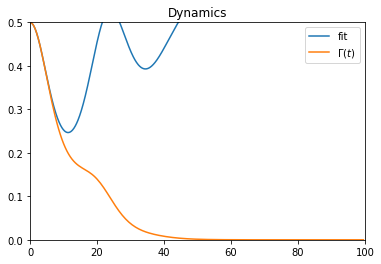

In [9]:
#file = open('SPDTMD_Dynamic.txt', 'r')
file = open('230307_cov_7.txt', 'r')
dr = np.loadtxt(file ,delimiter = " ", dtype = complex)
plt.figure()#figsize = (10,5))
ax1 = plt.subplot()#121)
ax1.set_title('Dynamics')
time = dr[:, 0].real
rdo01 = abs(dr[:, 2])
ax1.plot(time*au2fs, rdo01, label = "fit")
plt.plot(t*au2fs, np.exp(r_t)/2 ,label = "$\Gamma(t)$")
ax1.set_xlim(0, 100)
ax1.set_ylim(0, 0.5)
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
plt.legend()
plt.show()

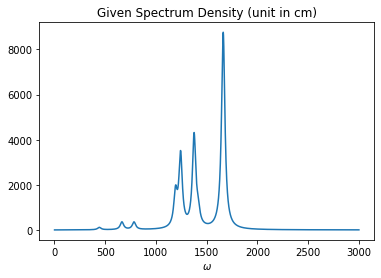

In [7]:
file = open('spd.txt', 'r')
file1 = open('spd (1).txt', 'r')
origin = np.loadtxt(file ,delimiter = " ")#, dtype = complex)
omg = origin[1:, 0]
j = origin[1:, 1]
origin1 = np.loadtxt(file1,delimiter = " ")#, dtype = complex)
omg1 = origin1[1:, 0]
j1 = origin1[1:, 1]
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
plt.plot(omg1, j1)
#plt.plot(omg1, j1)
plt.xlabel('$\omega$')
plt.title('Given Spectrum Density (unit in cm)')
plt.show()

learn_s = np.array([_re(j/ au2cm, omg/ au2cm, beta, t_i) for t_i in learn_domain])
learn_a = np.array([_im(j/ au2cm, omg/ au2cm, beta, t_i) for t_i in learn_domain])
learn_s1 = np.array([_re(j1/ au2cm, omg1/ au2cm, beta, t_i) for t_i in learn_domain])
learn_a1 = np.array([_im(j1/ au2cm, omg1/ au2cm, beta, t_i) for t_i in learn_domain])

#t_range = np.where(learn_domain*au2fs <= 100)
#t = learn_domain[t_range]


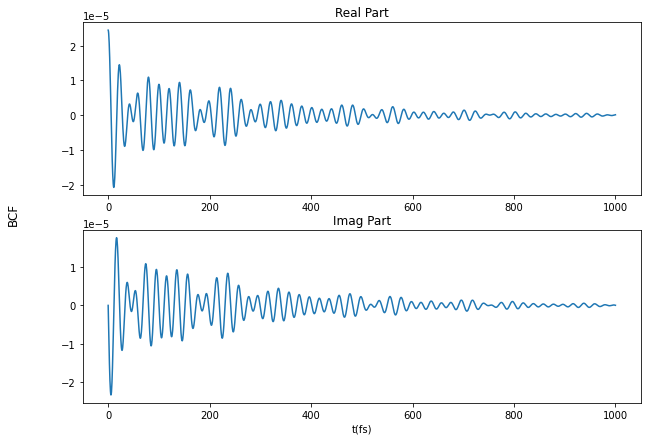

In [9]:
fig = plt.figure(figsize = (10,7))
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
ax1.plot(learn_domain* au2fs, learn_s1)
ax2.plot(learn_domain* au2fs, learn_a1)
ax1.set_title('Real Part')
ax2.set_title('Imag Part')
ax2.set_xlabel('t(fs)')
fig.supylabel('BCF')
plt.show()

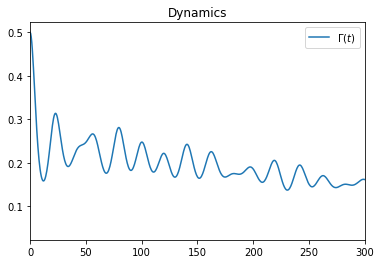

In [10]:
omg_ = np.where(omg1/au2cm <= 2000)
r_t = np.array([Gamma(j1/au2cm , omg1[omg_]/au2cm, beta, t_i) for t_i in learn_domain])

file = open('SPDTMD_wide_Dynamic_try.txt', 'r')
dr = np.loadtxt(file ,delimiter = " ", dtype = complex)
plt.title('Dynamics')
time = dr[:, 0].real
rdo01 = abs(dr[:, 2])
#plt.plot(time*au2fs, rdo01, label = "fit")
plt.plot(learn_domain*au2fs, np.exp(r_t)/2 ,label = "$\Gamma(t)$")
plt.xlim(0, 300)
plt.legend()
plt.show()

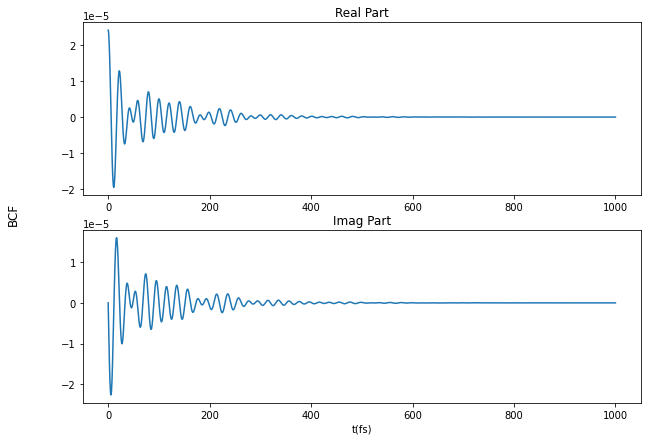

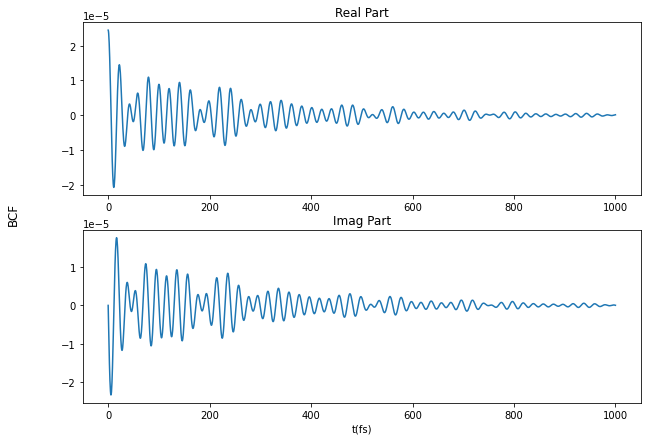

In [8]:
fig = plt.figure(figsize = (10,7))
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
ax1.plot(learn_domain* au2fs, learn_s)
ax2.plot(learn_domain* au2fs, learn_a)
ax1.set_title('Real Part')
ax2.set_title('Imag Part')
ax2.set_xlabel('t(fs)')
fig.supylabel('BCF')
plt.show()

np.savetxt('BCF_SPD_TMD_1.csv',[learn_s,learn_a], delimiter=',')

fig = plt.figure(figsize = (10,7))
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
ax1.plot(learn_domain* au2fs, learn_s1)
ax2.plot(learn_domain* au2fs, learn_a1)
ax1.set_title('Real Part')
ax2.set_title('Imag Part')
ax2.set_xlabel('t(fs)')
fig.supylabel('BCF')
plt.show()

In [44]:
abs(0.008091977288424024+0.0023492202973328423j)

0.00842608642501196